In [1]:
# import packages
import numpy as np 
import pandas as pd

import re 

from scipy.stats import chi2, nbinom

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white');
%config InlineBackend.figure_format='retina'

# Sample Guide-Gene Validations

In [2]:
# read in guide gene pairs used for Gasperini validations 
validation_guide_genes = pd.read_csv('./../results/validation_guide_gene_pairs.csv')
validation_guide_genes.head()

,target_site,gene,pvalue,gRNA_group,spacer_sequence
0,random_17,ENSG00000126934,0.424333,random_17,CGAGTTGTAAGCCCTTAAAA
1,random_17,ENSG00000126934,0.424333,random_17,TTTCTCTGTAAGTTACCATG
2,random_17,ENSG00000186153,0.434693,random_17,CGAGTTGTAAGCCCTTAAAA
3,random_17,ENSG00000186153,0.434693,random_17,TTTCTCTGTAAGTTACCATG
4,random_17,ENSG00000187607,0.658338,random_17,CGAGTTGTAAGCCCTTAAAA


In [3]:
# read in output file
line_count = 0
output_lines = []
with open('./../scripts/guide_gene_validation_out.txt') as file:
    for line in file:
        if line_count % 2 == 0:
            output_lines.append(line.split(','))
        line_count += 1

In [4]:
# read in function outputs from validations 
colnames = ['gene', 'spacer', 'null_0', 'null_disp', 'null_s', 'null_m',
            'null_fun', 'alt_0', 'alt_1', 'alt_disp', 'alt_s', 'alt_m', 'alt_fun']
glm_df = pd.DataFrame(output_lines, columns=colnames)
glm_df['null_fun'] = glm_df['null_fun'].astype(np.float64)
glm_df['alt_fun'] = glm_df['alt_fun'].astype(np.float64)
glm_df.head()

,gene,spacer,null_0,null_disp,null_s,null_m,null_fun,alt_0,alt_1,alt_disp,alt_s,alt_m,alt_fun
0,ENSG00000109445,CACCCTCCTGGGGAAGACCA,11.946751688271961,2.064872009395008,-0.31749833216661144,0.12515431529500068,231053.058420,11.947144925266377,-0.1433483937212663,2.065041128743462,-0.31783163402704817,0.12526961621895083,231049.544828
1,ENSG00000180628,AGAATTTCTTTGAACCCGGG,12.583255204885704,1.9570576880400377,0.0018299903679241097,0.09546325025317645,315306.903495,12.581530302405728,0.02910647738811141,1.971747174587747,-0.5919690745357571,0.11622135679605616,314925.584214
2,ENSG00000180628,CACCCTCCTGGGGAAGACCA,12.581624469694448,1.9717016981356674,-0.5919789452220149,0.11628382015502968,314925.851695,12.581565948073788,0.016984718326868813,1.9717336390760969,-0.5919685809201884,0.11625724003257892,314925.766014
3,ENSG00000038219,AGAATTTCTTTGAACCCGGG,10.663373018303368,1.837810798797602,-0.6453379454477937,0.17072447086830939,110456.776734,10.66267504164201,0.04807213067169945,1.832385439262192,-0.6826310549687375,0.14562905969773365,110455.877671
4,ENSG00000038219,CACCCTCCTGGGGAAGACCA,10.662834089535307,1.8323413007166753,-0.6826177193869198,0.14561961871697565,110456.023674,10.662651946096883,0.058993219675437115,1.8324535195264746,-0.6824677634831111,0.1456161117802497,110455.813244


In [8]:
# get shape of results data frame
glm_df.shape

(1991, 13)

In [9]:
# calculate p values
def run_likelihood_ratio_test(row):
    '''helper function to run likelihood test'''
    
    # negate function outputs to get null and alternative likelihood
    null_likelihood = -1 * row['null_fun']
    alt_likelihood = -1 * row['alt_fun']
    
    # calculate test statistic and p-value
    ts = -2 * (null_likelihood - alt_likelihood)
    pval = 1 - chi2.cdf(ts, 1)
    
    # return p-value
    return pval

p_values = glm_df.apply(run_likelihood_ratio_test, axis=1)
p_values

0       0.008028
1       0.000000
2       0.678904
3       0.179939
4       0.516509
          ...   
1986    0.233893
1987    0.000000
1988    0.643988
1989    0.509749
1990    0.000000
Length: 1991, dtype: float64

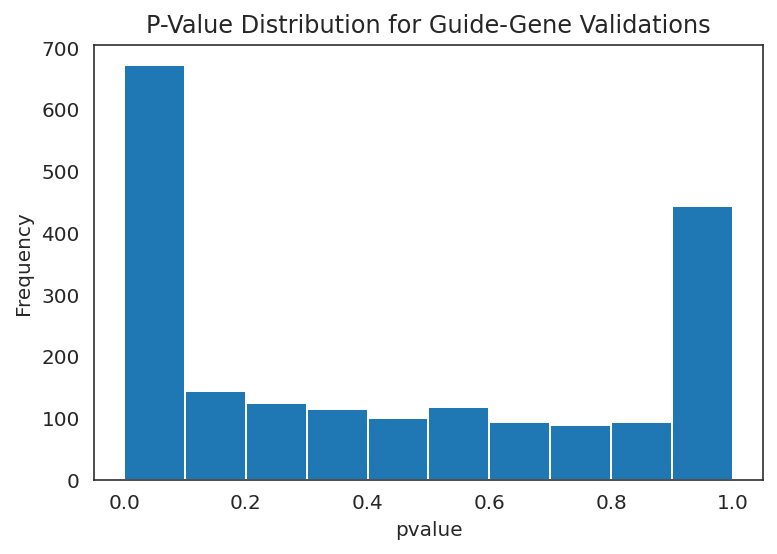

In [10]:
# check p value distribution for Gasperini validations
ax = plt.gca()
ax.set_title('P-Value Distribution for Guide-Gene Validations')
ax.set_xlabel('pvalue')
p_values.plot(kind='hist');

# TS-Gene Validations

In [2]:
# read in phenodata file 
colnames = open('/iblm/netapp/data1/external/Gasperini2019/suppl/GSE120861_at_scale.phenoData.colnames.txt') \
           .read().splitlines()

phenodata_df = pd.read_csv('./../data/phenodata.txt', sep=' ', names=colnames)
phenodata_df.head()

,sample,cell,total_umis,Size_Factor,gene,all_gene,barcode,read_count,umi_count,proportion,guide_count,sample_directory,ko_barcode_file,id,prep_batch,within_batch_chip,within_chip_lane,percent.mito
0,1A_1_SI-GA-E2,AAACCTGAGAGGTACC-1_1A_1_SI-GA-E2,17572.0,1.009682,chr10.845_top_two_chr1.11183_top_two_chr1.1129...,chr10.845_top_two_chr1.11183_top_two_chr1.1129...,AGAAAGCTCCTCCAGTTCAC_TGATCGCTTTGACTGTGACA_ACAA...,14135.0,964.0,0.969819,67.0,1A_1_SI-GA-E2,guide_libraries/1A_1.gRNAcaptured.txt,1A_1,prep_batch_1,within_batch_chip_A,within_chip_lane_1,0.058787
1,1A_1_SI-GA-E2,AAACCTGAGTCAATAG-1_1A_1_SI-GA-E2,8923.0,0.939677,chr1.12695_top_two_chr11.3294_top_two_chr1.679...,chr1.12695_top_two_chr11.3294_top_two_chr1.679...,GTAGAGCCTCCAGAACTGTG_AGGTTTATCCAGATGAACTG_CATC...,4329.0,293.0,0.844380,26.0,1A_1_SI-GA-E2,guide_libraries/1A_1.gRNAcaptured.txt,1A_1,prep_batch_1,within_batch_chip_A,within_chip_lane_1,0.036087
2,1A_1_SI-GA-E2,AAACCTGCAAACAACA-1_1A_1_SI-GA-E2,14637.0,0.990803,ALDH1A2_TSS_BRI3_TSS_chr10.1918_top_two_chr10....,ALDH1A2_TSS_BRI3_TSS_chr10.1918_top_two_chr10....,CCAAGGCGTCCTCAGACCAG_AGCTCCAGGAAGGACCCCCG_TCAC...,12362.0,884.0,0.950538,61.0,1A_1_SI-GA-E2,guide_libraries/1A_1.gRNAcaptured.txt,1A_1,prep_batch_1,within_batch_chip_A,within_chip_lane_1,0.069823
3,1A_1_SI-GA-E2,AAACCTGCACTTCTGC-1_1A_1_SI-GA-E2,22798.0,1.036578,C16orf91_TSS_chr1.11332_top_two_chr1.1933_top_...,C16orf91_TSS_chr1.11332_top_two_chr1.1933_top_...,GGCGTCAGTCGAGGAGTCAG_GCCAGCACTTCAGCTCACCG_GCTG...,7459.0,544.0,0.939551,39.0,1A_1_SI-GA-E2,guide_libraries/1A_1.gRNAcaptured.txt,1A_1,prep_batch_1,within_batch_chip_A,within_chip_lane_1,0.026187
4,1A_1_SI-GA-E2,AAACCTGCATGTAGTC-1_1A_1_SI-GA-E2,10136.0,0.952844,chr10.185_top_two_chr10.484_top_two_chr11.4167...,chr10.185_top_two_chr10.484_top_two_chr11.4167...,ATAAGGCACTCACATCCACC_GCTTGTCCCTAACACTCAGA_GGGC...,14831.0,1054.0,0.959927,37.0,1A_1_SI-GA-E2,guide_libraries/1A_1.gRNAcaptured.txt,1A_1,prep_batch_1,within_batch_chip_A,within_chip_lane_1,0.007991


In [3]:
phenodata_df.dropna().reset_index(drop=True).shape

(205797, 18)

In [4]:
# drop na values
phenodata_df = phenodata_df.dropna().reset_index(drop=True)
phenodata_df.head()

,sample,cell,total_umis,Size_Factor,gene,all_gene,barcode,read_count,umi_count,proportion,guide_count,sample_directory,ko_barcode_file,id,prep_batch,within_batch_chip,within_chip_lane,percent.mito
0,1A_1_SI-GA-E2,AAACCTGAGAGGTACC-1_1A_1_SI-GA-E2,17572.0,1.009682,chr10.845_top_two_chr1.11183_top_two_chr1.1129...,chr10.845_top_two_chr1.11183_top_two_chr1.1129...,AGAAAGCTCCTCCAGTTCAC_TGATCGCTTTGACTGTGACA_ACAA...,14135.0,964.0,0.969819,67.0,1A_1_SI-GA-E2,guide_libraries/1A_1.gRNAcaptured.txt,1A_1,prep_batch_1,within_batch_chip_A,within_chip_lane_1,0.058787
1,1A_1_SI-GA-E2,AAACCTGAGTCAATAG-1_1A_1_SI-GA-E2,8923.0,0.939677,chr1.12695_top_two_chr11.3294_top_two_chr1.679...,chr1.12695_top_two_chr11.3294_top_two_chr1.679...,GTAGAGCCTCCAGAACTGTG_AGGTTTATCCAGATGAACTG_CATC...,4329.0,293.0,0.844380,26.0,1A_1_SI-GA-E2,guide_libraries/1A_1.gRNAcaptured.txt,1A_1,prep_batch_1,within_batch_chip_A,within_chip_lane_1,0.036087
2,1A_1_SI-GA-E2,AAACCTGCAAACAACA-1_1A_1_SI-GA-E2,14637.0,0.990803,ALDH1A2_TSS_BRI3_TSS_chr10.1918_top_two_chr10....,ALDH1A2_TSS_BRI3_TSS_chr10.1918_top_two_chr10....,CCAAGGCGTCCTCAGACCAG_AGCTCCAGGAAGGACCCCCG_TCAC...,12362.0,884.0,0.950538,61.0,1A_1_SI-GA-E2,guide_libraries/1A_1.gRNAcaptured.txt,1A_1,prep_batch_1,within_batch_chip_A,within_chip_lane_1,0.069823
3,1A_1_SI-GA-E2,AAACCTGCACTTCTGC-1_1A_1_SI-GA-E2,22798.0,1.036578,C16orf91_TSS_chr1.11332_top_two_chr1.1933_top_...,C16orf91_TSS_chr1.11332_top_two_chr1.1933_top_...,GGCGTCAGTCGAGGAGTCAG_GCCAGCACTTCAGCTCACCG_GCTG...,7459.0,544.0,0.939551,39.0,1A_1_SI-GA-E2,guide_libraries/1A_1.gRNAcaptured.txt,1A_1,prep_batch_1,within_batch_chip_A,within_chip_lane_1,0.026187
4,1A_1_SI-GA-E2,AAACCTGCATGTAGTC-1_1A_1_SI-GA-E2,10136.0,0.952844,chr10.185_top_two_chr10.484_top_two_chr11.4167...,chr10.185_top_two_chr10.484_top_two_chr11.4167...,ATAAGGCACTCACATCCACC_GCTTGTCCCTAACACTCAGA_GGGC...,14831.0,1054.0,0.959927,37.0,1A_1_SI-GA-E2,guide_libraries/1A_1.gRNAcaptured.txt,1A_1,prep_batch_1,within_batch_chip_A,within_chip_lane_1,0.007991


In [5]:
prep_batch_1 = (phenodata_df['prep_batch'] == 'prep_batch_1').astype(np.int64)

In [42]:
def get_guide_names(guides):
    '''regex function to separate guide names'''
    
    guide_list = re.findall(r"[A-Za-z0-9]*\_TSS|chr[A-Z0-9]{1,2}\.\w*top_two|chr[A-Z0-9]{1,2}\.\w*second_two|bassik_mch|random_\d+|scrambled_\d+", guides)
    return guide_list

In [43]:
phenodata_df['guides'] = phenodata_df['gene'].apply(get_guide_names)
phenodata_df.head()

,sample,cell,total_umis,Size_Factor,gene,all_gene,barcode,read_count,umi_count,proportion,guide_count,sample_directory,ko_barcode_file,id,prep_batch,within_batch_chip,within_chip_lane,percent.mito,guides
0,1A_1_SI-GA-E2,AAACCTGAGAGGTACC-1_1A_1_SI-GA-E2,17572.0,1.009682,chr10.845_top_two_chr1.11183_top_two_chr1.1129...,chr10.845_top_two_chr1.11183_top_two_chr1.1129...,AGAAAGCTCCTCCAGTTCAC_TGATCGCTTTGACTGTGACA_ACAA...,14135.0,964.0,0.969819,67.0,1A_1_SI-GA-E2,guide_libraries/1A_1.gRNAcaptured.txt,1A_1,prep_batch_1,within_batch_chip_A,within_chip_lane_1,0.058787,"[chr10.845_top_two, chr1.11183_top_two, chr1.1..."
1,1A_1_SI-GA-E2,AAACCTGAGTCAATAG-1_1A_1_SI-GA-E2,8923.0,0.939677,chr1.12695_top_two_chr11.3294_top_two_chr1.679...,chr1.12695_top_two_chr11.3294_top_two_chr1.679...,GTAGAGCCTCCAGAACTGTG_AGGTTTATCCAGATGAACTG_CATC...,4329.0,293.0,0.844380,26.0,1A_1_SI-GA-E2,guide_libraries/1A_1.gRNAcaptured.txt,1A_1,prep_batch_1,within_batch_chip_A,within_chip_lane_1,0.036087,"[chr1.12695_top_two, chr11.3294_top_two, chr1...."
2,1A_1_SI-GA-E2,AAACCTGCAAACAACA-1_1A_1_SI-GA-E2,14637.0,0.990803,ALDH1A2_TSS_BRI3_TSS_chr10.1918_top_two_chr10....,ALDH1A2_TSS_BRI3_TSS_chr10.1918_top_two_chr10....,CCAAGGCGTCCTCAGACCAG_AGCTCCAGGAAGGACCCCCG_TCAC...,12362.0,884.0,0.950538,61.0,1A_1_SI-GA-E2,guide_libraries/1A_1.gRNAcaptured.txt,1A_1,prep_batch_1,within_batch_chip_A,within_chip_lane_1,0.069823,"[ALDH1A2_TSS, BRI3_TSS, chr10.1918_top_two, ch..."
3,1A_1_SI-GA-E2,AAACCTGCACTTCTGC-1_1A_1_SI-GA-E2,22798.0,1.036578,C16orf91_TSS_chr1.11332_top_two_chr1.1933_top_...,C16orf91_TSS_chr1.11332_top_two_chr1.1933_top_...,GGCGTCAGTCGAGGAGTCAG_GCCAGCACTTCAGCTCACCG_GCTG...,7459.0,544.0,0.939551,39.0,1A_1_SI-GA-E2,guide_libraries/1A_1.gRNAcaptured.txt,1A_1,prep_batch_1,within_batch_chip_A,within_chip_lane_1,0.026187,"[C16orf91_TSS, chr1.11332_top_two, chr1.1933_t..."
4,1A_1_SI-GA-E2,AAACCTGCATGTAGTC-1_1A_1_SI-GA-E2,10136.0,0.952844,chr10.185_top_two_chr10.484_top_two_chr11.4167...,chr10.185_top_two_chr10.484_top_two_chr11.4167...,ATAAGGCACTCACATCCACC_GCTTGTCCCTAACACTCAGA_GGGC...,14831.0,1054.0,0.959927,37.0,1A_1_SI-GA-E2,guide_libraries/1A_1.gRNAcaptured.txt,1A_1,prep_batch_1,within_batch_chip_A,within_chip_lane_1,0.007991,"[chr10.185_top_two, chr10.484_top_two, chr11.4..."


In [44]:
test = phenodata_df.head()
target_sites = pd.Series(pd.Series(test['guides'].sum()).unique())
target_sites

0       chr10.845_top_two
1      chr1.11183_top_two
2      chr1.11293_top_two
3      chr11.1791_top_two
4      chr1.12598_top_two
              ...        
222     chr7.5369_top_two
223     chr8.1657_top_two
224      chrX.276_top_two
225              LMO2_TSS
226           TIMM17B_TSS
Length: 227, dtype: object

In [45]:
(test['guides'].apply(lambda x: target_sites.isin(x))).astype(np.int64).T

,0,1,2,3,4
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
222,0,0,0,0,1
223,0,0,0,0,1
224,0,0,0,0,1
225,0,0,0,0,1


# BREAK

In [2]:
# read in output file
line_count = 0
output_lines = []
with open('./../scripts/ts_gene_validation_out.txt') as file:
    for line in file:
        if line_count % 2 == 0:
            output_lines.append(line.split(','))
        line_count += 1

In [3]:
# read in function outputs 
colnames = ['gene', 'spacer', 'null_0', 'null_disp', 'null_s', 'null_m',
            'null_fun', 'alt_0', 'alt_1', 'alt_disp', 'alt_s', 'alt_m', 'alt_fun']
glm_df = pd.DataFrame(output_lines, columns=colnames)
glm_df['null_fun'] = glm_df['null_fun'].astype(np.float64)
glm_df['alt_fun'] = glm_df['alt_fun'].astype(np.float64)
glm_df.head()

,gene,spacer,null_0,null_disp,null_s,null_m,null_fun,alt_0,alt_1,alt_disp,alt_s,alt_m,alt_fun
0,ENSG00000138279,random_2,12.488859256647316,2.3358935732145696,0.21003967387202446,0.009259676960422755,298987.311577,12.489002931770472,-0.027191861786139197,2.335980947925038,0.2099897890715,0.009248129290365472,298986.904657
1,ENSG00000131966,random_8,11.615462695115914,1.6231502772207644,-1.1023504629105827,-0.10715617328277185,200795.213073,11.615631081454161,-0.04447010001363863,1.6231538705114428,-1.1023789617915232,-0.10716213914924,200794.880533
2,ENSG00000138433,scrambled_16,11.925646507595943,1.326568179034901,-2.166322951220355,-0.26235723557948143,240660.857472,11.926697765969713,1.0199931794654304,1.3093963443116234,-1.9382854086407189,-0.20869810630948452,241025.403568
3,ENSG00000100714,scrambled_9,11.651429012498788,2.088689496314685,2.4125088682056957,0.38610737539955164,194696.877085,11.651274993490052,0.027324892289954134,2.0886353891556944,2.4124979296343785,0.38610280042659206,194696.669582
4,ENSG00000143727,scrambled_5,13.497475257545858,2.808340986391502,-0.10481555698483902,-0.2306123515140202,428338.474613,13.500961472194634,0.0066762583267503065,2.8953839133738706,0.29444727179905583,-0.08677357273473842,427730.127713


In [4]:
# get shape of function outputs
glm_df.shape

(1000, 13)

In [5]:
# calculate p values
def run_likelihood_ratio_test(row):
    '''helper function to run likelihood test'''
    
    # negate function outputs to get null and alternative likelihood
    null_likelihood = -1 * row['null_fun']
    alt_likelihood = -1 * row['alt_fun']
    
    # calculate test statistic and p-value
    ts = -2 * (null_likelihood - alt_likelihood)
    pval = 1 - chi2.cdf(ts, 1)
    
    # return p-value
    return pval

p_values = glm_df.apply(run_likelihood_ratio_test, axis=1)
p_values

0      0.366987
1      0.414772
2      1.000000
3      0.519439
4      0.000000
         ...   
995    0.016601
996    0.002061
997    0.107410
998    0.917203
999    0.923057
Length: 1000, dtype: float64

In [18]:
(p_values < 0.0001).mean()

0.224

<AxesSubplot:ylabel='Frequency'>

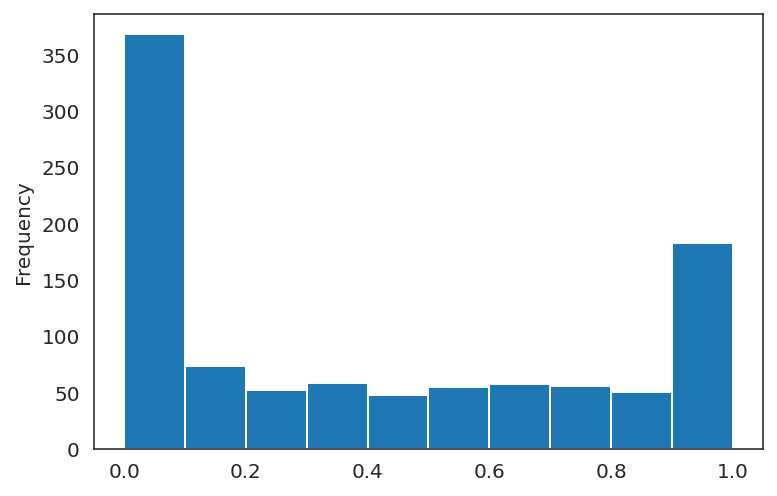

In [20]:
p_values.plot(kind='hist')

In [10]:
ts_gene_pairs = pd.read_csv('./../results/validation_ts_gene_pairs.csv')
ts_gene_pairs['validate_pval'] = p_values
ts_gene_pairs = ts_gene_pairs.rename(columns={'pvalue': 'orig_pvalue'})
ts_gene_pairs

,target_site,gene,orig_pvalue,validate_pval
0,random_22,ENSG00000268172,6.655708e-01,0.366987
1,random_11,ENSG00000236320,3.907068e-01,0.414772
2,scrambled_22,ENSG00000141026,4.041582e-01,1.000000
3,random_10,ENSG00000063180,9.509650e-01,0.519439
4,random_10,ENSG00000066926,4.466476e-01,0.000000
...,...,...,...,...
995,random_21,ENSG00000151553,6.167115e-01,0.016601
996,chr1.8052_top_two,ENSG00000116830,2.288284e-13,0.002061
997,scrambled_13,ENSG00000012660,9.361151e-01,0.107410
998,random_19,ENSG00000174928,8.161061e-01,0.917203


<AxesSubplot:ylabel='Frequency'>

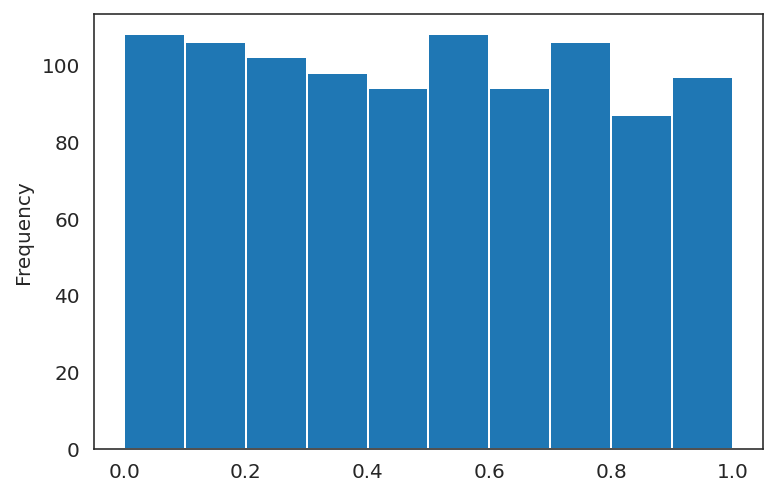

In [21]:
ts_gene_pairs['orig_pvalue'].plot(kind='hist')

In [19]:
(ts_gene_pairs['orig_pvalue'] < 0.0001).mean()

0.003

In [21]:
orig_signif = ts_gene_pairs['orig_pvalue'] < 0.05
validate_signif = ts_gene_pairs['validate_pval'] < 0.05
(orig_signif == validate_signif).mean()

0.668

In [22]:
guide_gene_pairs = pd.read_csv('./../data/validate_ts_genes.csv')
guide_gene_pairs['target_site'] = guide_gene_pairs['target_site'].str.lower()
guide_gene_pairs.head()

,target_site,gene,pvalue
0,random_22,ENSG00000268172,0.665571
1,random_11,ENSG00000236320,0.390707
2,scrambled_22,ENSG00000141026,0.404158
3,random_10,ENSG00000063180,0.950965
4,random_10,ENSG00000066926,0.446648


In [6]:
cell_ts_matrix = pd.read_hdf('../data/cell_ts_matrix.h5')
cell_ts_matrix.head()

KeyboardInterrupt: 

In [ ]:
cell_ts_matrix.index = cell_ts_matrix.index.str.lower()

In [ ]:
guide_gene_pairs['target_site'].isin(cell_ts_matrix.index).sum()

In [7]:
guide_gene_pairs[guide_gene_pairs['target_site'].isin(cell_ts_matrix.index)]

,target_site,gene,pvalue
0,random_22,ENSG00000268172,6.655708e-01
1,random_11,ENSG00000236320,3.907068e-01
2,scrambled_22,ENSG00000141026,4.041582e-01
3,random_10,ENSG00000063180,9.509650e-01
4,random_10,ENSG00000066926,4.466476e-01
...,...,...,...
995,random_21,ENSG00000151553,6.167115e-01
996,chr1.8052_top_two,ENSG00000116830,2.288284e-13
997,scrambled_13,ENSG00000012660,9.361151e-01
998,random_19,ENSG00000174928,8.161061e-01


In [21]:
cell_ts_matrix

cell,AAACCTGAGAGGTACC-1_1A_1_SI-GA-E2,AAACCTGAGTCAATAG-1_1A_1_SI-GA-E2,AAACCTGCAAACAACA-1_1A_1_SI-GA-E2,AAACCTGCACTTCTGC-1_1A_1_SI-GA-E2,AAACCTGCATGTAGTC-1_1A_1_SI-GA-E2,AAACCTGGTAGCGCAA-1_1A_1_SI-GA-E2,AAACCTGGTAGGGACT-1_1A_1_SI-GA-E2,AAACCTGGTATATGAG-1_1A_1_SI-GA-E2,AAACCTGGTCAAAGCG-1_1A_1_SI-GA-E2,AAACCTGGTCTTCAAG-1_1A_1_SI-GA-E2,...,TTTGTCACAACGATGG-1_2B_8_SI-GA-H9,TTTGTCACACTTCTGC-1_2B_8_SI-GA-H9,TTTGTCACAGATAATG-1_2B_8_SI-GA-H9,TTTGTCACAGCCAGAA-1_2B_8_SI-GA-H9,TTTGTCACATTAGGCT-1_2B_8_SI-GA-H9,TTTGTCAGTACCTACA-1_2B_8_SI-GA-H9,TTTGTCAGTATCACCA-1_2B_8_SI-GA-H9,TTTGTCAGTTCAGACT-1_2B_8_SI-GA-H9,TTTGTCAGTTCTGTTT-1_2B_8_SI-GA-H9,TTTGTCATCAAAGTAG-1_2B_8_SI-GA-H9
chr10.845_top_two,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr1.11183_top_two,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr1.11293_top_two,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr11.1791_top_two,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr1.12598_top_two,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rbmx_tss,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
rpl31_tss,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr3.3105_top_two,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr9.1168_top_two,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
ts_gene_pairs = pd.read_csv('./../results/validation_ts_gene_pairs.csv')
ts_gene_pairs.head()

,target_site,gene,pvalue
0,random_22,ENSG00000268172,0.665571
1,random_11,ENSG00000236320,0.390707
2,scrambled_22,ENSG00000141026,0.404158
3,random_10,ENSG00000063180,0.950965
4,random_10,ENSG00000066926,0.446648


In [8]:
# set path to project directory 
project_path = '/iblm/netapp/home/karthik/gasperini_project/'
data_path = '/iblm/netapp/data1/external/Gasperini2019/'

In [9]:
# read in cell-guide matrix
print('loading in cell-guide matrix...')
cell_ts_matrix = pd.read_hdf(project_path + 'data/cell_ts_matrix.h5')
cell_ts_matrix.index = cell_ts_matrix.index.str.lower()

loading in cell-guide matrix...


In [10]:
# read in cell cycle scores and merge into single dataframe
print('reading in cell cycle scores...')
s_scores = pd.read_csv(project_path + 'data/s_scores.csv', index_col=0)
g2m_scores = pd.read_csv(project_path + 'data/g2m_scores.csv', index_col=0)
s_scores.index = s_scores.index.rename('cell')
g2m_scores.index = g2m_scores.index.rename('cell')
merged_scores = pd.merge(s_scores, g2m_scores, on='cell')

# filter scores to only include cells in guide matrix
in_guide_matrix = merged_scores.index.isin(cell_ts_matrix.columns)
merged_scores = merged_scores[in_guide_matrix]
cell_s_scores = merged_scores['S.Score']
cell_g2m_scores = merged_scores['G2M.Score']

reading in cell cycle scores...


In [11]:
phenodata_df = phenodata_df.dropna().reset_index(drop=True)

In [16]:
cell_guide_counts = phenodata_df['guide_count']
percent_mito = phenodata_df['percent.mito']
prep_batch_1 = (phenodata_df['prep_batch'] == 'prep_batch_1').astype(np.int64)
prep_batch_2 = (phenodata_df['prep_batch'] == 'prep_batch_2').astype(np.int64)
cell_guide_counts.index = cell_s_scores.index
percent_mito.index = cell_s_scores.index
prep_batch_1.index = cell_s_scores.index
prep_batch_2.index = cell_s_scores.index
cell_guide_counts

cell
AAACCTGAGAGGTACC-1_1A_1_SI-GA-E2    67.0
AAACCTGAGTCAATAG-1_1A_1_SI-GA-E2    26.0
AAACCTGCAAACAACA-1_1A_1_SI-GA-E2    61.0
AAACCTGCACTTCTGC-1_1A_1_SI-GA-E2    39.0
AAACCTGCATGTAGTC-1_1A_1_SI-GA-E2    37.0
                                    ... 
TTTGTCAGTACCTACA-1_2B_8_SI-GA-H9    31.0
TTTGTCAGTATCACCA-1_2B_8_SI-GA-H9    33.0
TTTGTCAGTTCAGACT-1_2B_8_SI-GA-H9     3.0
TTTGTCAGTTCTGTTT-1_2B_8_SI-GA-H9     1.0
TTTGTCATCAAAGTAG-1_2B_8_SI-GA-H9    35.0
Name: guide_count, Length: 205797, dtype: float64

In [28]:
np.exp(1 + 0.5 * cell_s_scores + 0.5 * cell_g2m_scores + 0.5 * cell_guide_counts + 0.5 * percent_mito + 0.5 * prep_batch_1 + 0.5 * prep_batch_2 + np.log(scalers_arr))

cell
AAACCTGAGAGGTACC-1_1A_1_SI-GA-E2    7.466663e+09
AAACCTGAGTCAATAG-1_1A_1_SI-GA-E2    4.404802e+00
AAACCTGCAAACAACA-1_1A_1_SI-GA-E2    2.498809e+08
AAACCTGCACTTCTGC-1_1A_1_SI-GA-E2    7.458742e+03
AAACCTGCATGTAGTC-1_1A_1_SI-GA-E2    1.029759e+03
                                        ...     
TTTGTCAGTACCTACA-1_2B_8_SI-GA-H9    1.230496e+02
TTTGTCAGTATCACCA-1_2B_8_SI-GA-H9    2.992677e+02
TTTGTCAGTTCAGACT-1_2B_8_SI-GA-H9    6.593913e-05
TTTGTCAGTTCTGTTT-1_2B_8_SI-GA-H9    1.168659e-05
TTTGTCATCAAAGTAG-1_2B_8_SI-GA-H9    4.066027e+02
Length: 205797, dtype: float64

In [27]:
0.5 * prep_batch_1

cell
AAACCTGAGAGGTACC-1_1A_1_SI-GA-E2    0.5
AAACCTGAGTCAATAG-1_1A_1_SI-GA-E2    0.5
AAACCTGCAAACAACA-1_1A_1_SI-GA-E2    0.5
AAACCTGCACTTCTGC-1_1A_1_SI-GA-E2    0.5
AAACCTGCATGTAGTC-1_1A_1_SI-GA-E2    0.5
                                   ... 
TTTGTCAGTACCTACA-1_2B_8_SI-GA-H9    0.0
TTTGTCAGTATCACCA-1_2B_8_SI-GA-H9    0.0
TTTGTCAGTTCAGACT-1_2B_8_SI-GA-H9    0.0
TTTGTCAGTTCTGTTT-1_2B_8_SI-GA-H9    0.0
TTTGTCATCAAAGTAG-1_2B_8_SI-GA-H9    0.0
Name: prep_batch, Length: 205797, dtype: float64

In [21]:
# read in scaling factors
print('reading in scaling factors...')
scaling_factors = pd.read_csv(project_path + 'data/scaling_factors.csv')
scaling_factors.columns = ['cell', 'scaling_factor']
scaling_factors = scaling_factors.set_index('cell')
scaling_factors = scaling_factors.merge(cell_ts_matrix.iloc[0], on='cell')
scaling_factors = scaling_factors.iloc[:, 0]
scaling_factors_arr = scaling_factors.values # np.array for faster computation
scalers_arr = scaling_factors_arr

reading in scaling factors...


In [22]:
scalers_arr

array([4.66272975e-06, 2.36693392e-06, 3.88233435e-06, ...,
       3.97948562e-06, 1.36675370e-06, 2.52142035e-06])